In [1]:
import os
import struct
import ctypes

In [13]:
FNAME = '/project/druhe/SB320-202012281240-lba_outer.vis'

In [14]:
MAGIC = '0x000000003B98F002'

In [15]:
int(MAGIC, 0)

999878658

In [16]:
!which python

/home/druhe/projects/interferometry/.venv_py2/bin/python


In [56]:
NANT = 576
SUB = 320
NCHAN = 1
POL2REC = 4
LEN_HDR = 512

In [57]:
NBLINE = NANT * (NANT + 1) / 2

In [58]:
NBLINE

166176

In [59]:
NANT * (NANT + 1) / 2 - NANT * (NANT - 1) / 2

576

In [60]:
PAYLOAD = NBLINE * NCHAN * POL2REC * 8# Final *2 unknown
RECSIZE = PAYLOAD + LEN_HDR


In [61]:
PAYLOAD

5317632

In [62]:
5318144-512

5317632

In [63]:
RECSIZE

5318144

In [64]:
fsize = os.path.getsize(FNAME)

In [65]:
nrec = fsize / RECSIZE

In [66]:
fsize, RECSIZE

(2222984192, 5318144)

In [67]:
nrec

418

In [68]:
from tqdm import trange

In [69]:
with open(FNAME, 'rb') as f:
    s = f.read()

In [31]:
magic, = struct.unpack("<Q", s[0:8])

In [32]:
ctypes.c_uint32(magic).value

999878658L

In [33]:
PAYLOAD + LEN_HDR

15953408

In [34]:
import re

In [36]:
header_locs = [(m.start(0), m.end(0)) for m in re.finditer('\x02\xf0\x98;@\x02\x04\x0f', s)]

In [41]:
header_locs[0]

(0, 8)

In [42]:
header_locs[1]

(5318144, 5318152)

In [37]:
len(header_locs)

418

In [38]:
nrec = fsize / RECSIZE

In [39]:
nrec

139

In [24]:
with open(FNAME, 'rb') as f:
    f.seek(RECSIZE, 0)
    hdr = f.read(LEN_HDR)
    magic = struct.unpack("<Q", hdr[0:8])

In [25]:
magic

(1081992285376802818,)

In [26]:
import numpy as np

In [27]:
def read_vis(f):
    s = f.read(RECSIZE)

    header = s[:512]
    data = s[512:]


    magic, = struct.unpack("<Q", s[0:8])
    magic = np.uint32(magic)
    print(magic)
    assert int(magic) == int(MAGIC, 0)

    data = np.reshape(np.fromstring(data, dtype=np.complex64), (NBLINE, 3, 4))
    return data

In [28]:
# xx, xy, yx, yy

with open(FNAME, 'rb') as f:
    
    f.seek(355 * RECSIZE)

    vis = read_vis(f)

999878658


/home/druhe/projects/interferometry/.venv_py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


In [29]:
vis.shape

(166176, 3, 4)

In [30]:
data = vis

In [31]:
import gfft

In [32]:
from scipy.constants import c

def parse_lba_antennafield(f, subbands):

    with open(f) as f:
        lines = [line.strip() for line in f.readlines()]

    positions = []
    lba_start = lines.index('LBA')
    data_start = lba_start + 3
    data_end = lines.index(']', lba_start)
    num_antennas = data_end - data_start
    offset = [float(x) for x in lines[lba_start+1].split()[2:5]]
    for line in lines[data_start: data_end]:
        x, y, z = [float(x) for x in line.split()[0:3]]
        positions.append(
            [offset[0] + x, offset[1] + y, offset[2] + z]
        )

    rot_matrix = []
    lba_rot_start = lines.index('ROTATION_MATRIX LBA')
    data_start = lba_rot_start + 2
    data_end = lba_rot_start + 5
    for line in lines[data_start: data_end]:
        x, y, z = [float(x) for x in line.split()[0:3]]
        rot_matrix.append(
            [x, y, z]
        )

    A = np.array(positions)
    R = np.array(rot_matrix)
    L = A.dot(R)
    print(len(L))

    u, v = [], []

    for a1 in range(0, num_antennas):
        for a2 in range(0, a1+1):
            u.append(L[a1, 0] - L[a2, 0])
            v.append(L[a1, 1] - L[a2, 1])

    # Don't know what these constants are. Probably converting to wavelengths. 
    return [np.ravel([(np.array(u)/(c/(s*(2e8/1024))/2.0)) for s in subbands]),
            np.ravel([(np.array(v)/(c/(s*(2e8/1024))/2.0)) for s in subbands])]


In [33]:
in_ax = parse_lba_antennafield('./a12-AntennaField.conf', [288])

576


In [34]:
in_ax[0].shape

(166176,)

In [35]:
res = 2300
dx = 1.0 / res
in_ax = parse_lba_antennafield('./a12-AntennaField.conf', [288])
out_ax = [(dx, res), (dx, res)]
 

576


In [36]:
L = np.linspace(-1, 1, res)
M = np.linspace(-1, 1, res) 
mask = np.ones((res, res))
xv, yv = np.meshgrid(L, M)
mask[np.sqrt(np.array(xv**2 + yv**2)) > 1] = np.nan


In [37]:
image = np.rot90(np.real(gfft.gfft(np.ravel(data), in_ax, out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask

In [38]:
image.shape

(2300, 2300)

In [37]:
import matplotlib.pyplot as plt

In [38]:
from itertools import combinations
combinations = list(combinations([0, 1, 2, 3], 2))

In [39]:
data.shape

(166176, 3, 4)

In [40]:
combinations

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [41]:

for c in combinations:
    image = data[:, :, c].mean(axis=(-1, -2))
    # image = np.rot90(np.real(gfft.gfft(np.ravel(image), in_ax, out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask
    # plt.figure(figsize=(16, 16))
    # plt.imshow(image, vmin=np.nanmean(image) - 3 * np.nanstd(image), vmax=np.nanmean(image) + 3 * np.nanstd(image))
    # plt.show()

In [42]:
data.shape

(166176, 3, 4)

In [43]:
image = data.copy()

In [44]:
from scipy.stats import sigmaclip

In [45]:
res = sigmaclip(image, low=3, high=3)
l, h = res.lower, res.upper

In [46]:
image[(image < l) | (image > h)] = 0j

In [47]:
(image > np.mean(image) + 3 * np.std(image)).any()

True

(array([   6795.,   36693.,   73009.,  118827., 1080306.,  442723.,
         119448.,   73016.,   36450.,    6845.]),
 array([-2.2876480e+08, -1.8300274e+08, -1.3724067e+08, -9.1478600e+07,
        -4.5716532e+07,  4.5536000e+04,  4.5807604e+07,  9.1569672e+07,
         1.3733174e+08,  1.8309381e+08,  2.2885587e+08], dtype=float32),
 <a list of 10 Patch objects>)

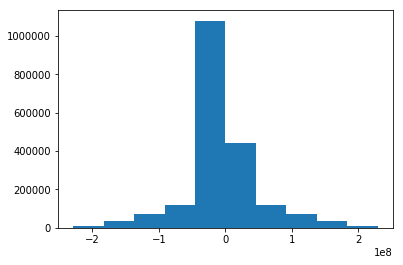

In [48]:
plt.hist(np.real(image).flatten())

In [49]:
# image = np.median(image, axis=(-1, -2))

# image = np.rot90(np.real(gfft.gfft(np.ravel(image), in_ax, out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask



# plt.figure(figsize=(16, 16))
# plt.imshow(image, vmin=np.nanmean(image) - 3 * np.nanstd(image), vmax=np.nanmean(image) + 3 * np.nanstd(image))
# plt.show()

(166176,)


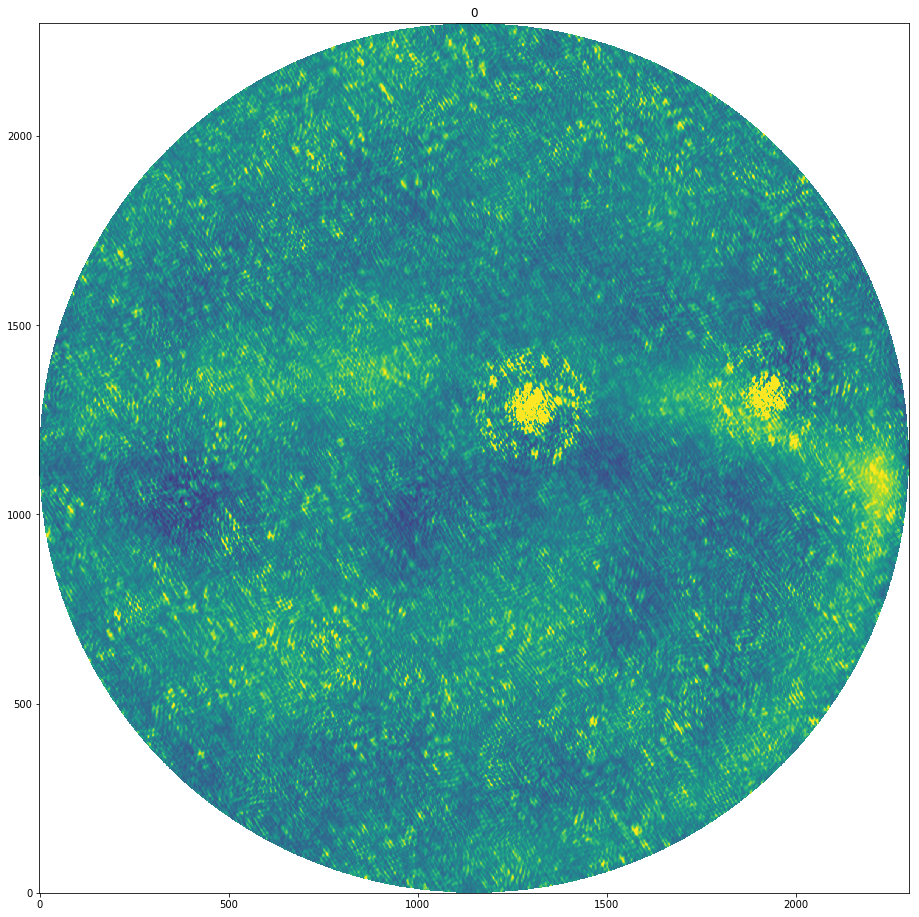

(166176,)


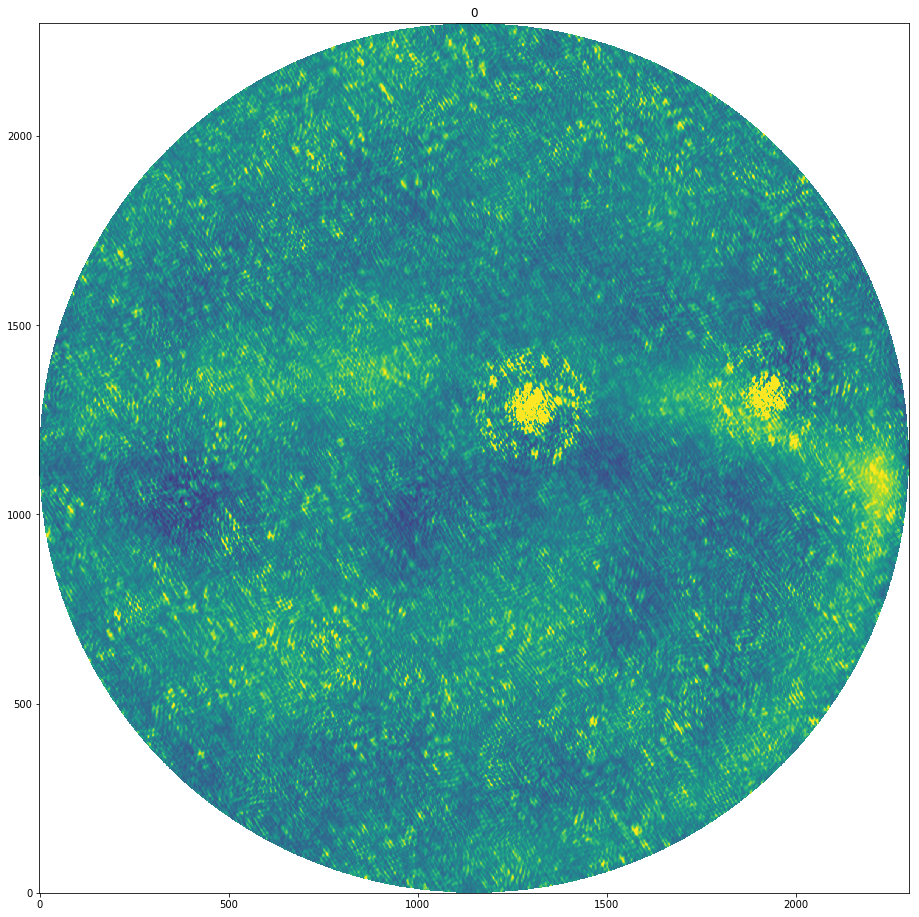

(166176,)


KeyboardInterrupt: 

In [50]:






for c in combinations:
#     im = np.median(image[:, :, c], axis=(-1, -2))
    im = np.mean(image[:, :, 0], axis=(-1))
    print(im.shape)
#     plt.hist(im)
#     plt.show()
    
#     m = im == 0
#     im = im[m]
    ia0 = in_ax[0].copy()
#     ia0 = ia0[m]
    
    ia1 = ia1 = in_ax[1].copy()
#     ia1 = ia1[m]
#     print(im.shape)
#     break
    im = np.rot90(np.real(gfft.gfft(np.ravel(im), [ia0, ia1], out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask


    plt.figure(figsize=(16, 16))
    plt.imshow(im, vmin=np.nanmean(im) - 3 * np.nanstd(im), vmax=np.nanmean(im) + 3 * np.nanstd(im), origin='lower')
    plt.title('0')
    plt.show()



In [ ]:
np.nanmax(im)

(166176,)


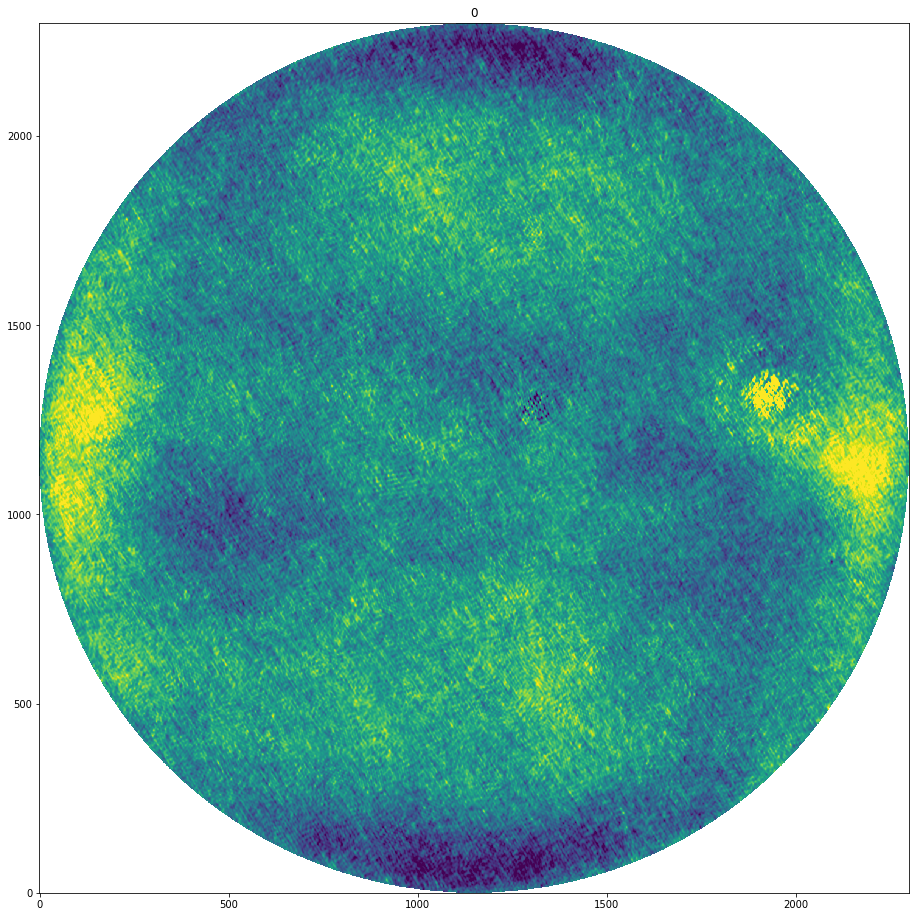

In [51]:
im = np.mean(image[:, :, 1], axis=(-1))
print(im.shape)
#     plt.hist(im)
#     plt.show()

#     m = im == 0
#     im = im[m]
ia0 = in_ax[0].copy()
#     ia0 = ia0[m]

ia1 = ia1 = in_ax[1].copy()
#     ia1 = ia1[m]
#     print(im.shape)
#     break
im = np.rot90(np.real(gfft.gfft(np.ravel(im), [ia0, ia1], out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask


plt.figure(figsize=(16, 16))
plt.imshow(im, vmin=np.nanmean(im) - 3 * np.nanstd(im), vmax=np.nanmean(im) + 3 * np.nanstd(im), origin='lower')
plt.title('0')
plt.show()




(166176,)


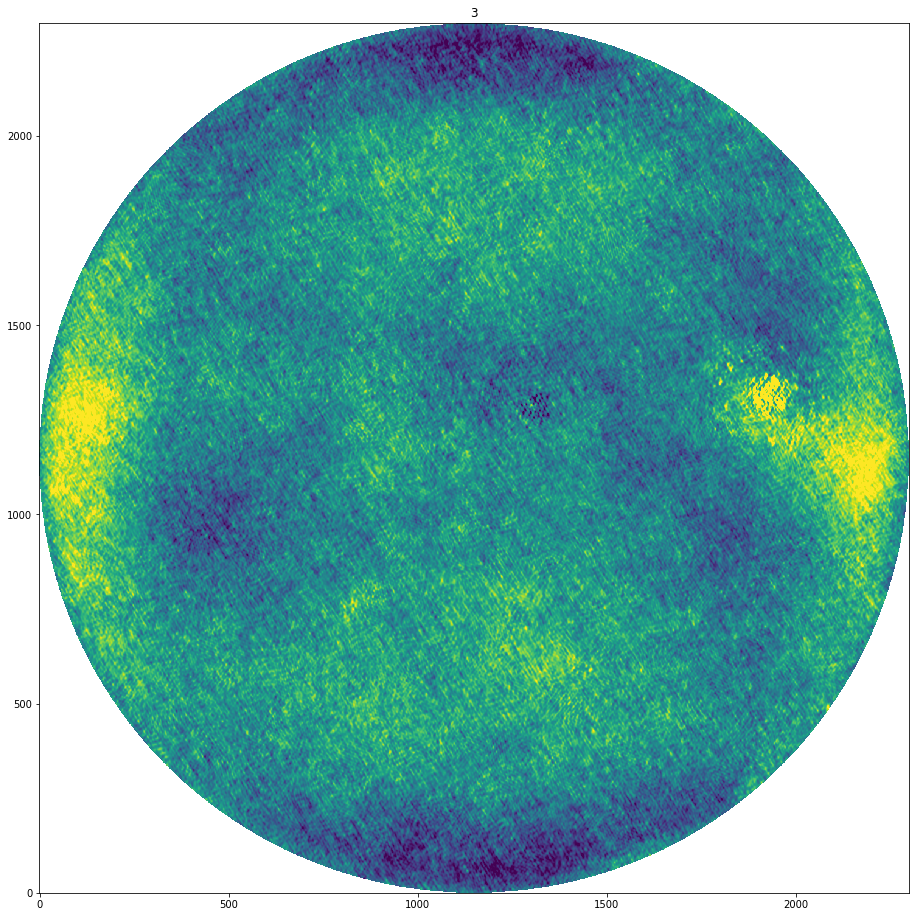

In [52]:
im = np.mean(image[:, :, 2], axis=(-1))
# im = image[:, 0, 2]
print(im.shape)

#     plt.hist(im)
#     plt.show()

#     m = im == 0
#     im = im[m]
ia0 = in_ax[0].copy()
#     ia0 = ia0[m]

ia1 = ia1 = in_ax[1].copy()
#     ia1 = ia1[m]
#     print(im.shape)
#     break
im = np.rot90(np.real(gfft.gfft(np.ravel(im), [ia0, ia1], out_ax, enforce_hermitian_symmetry=True, verbose=False, W=6, alpha=1.5)), 1)*mask


plt.figure(figsize=(16, 16))
plt.imshow(im, vmin=np.nanmean(im) - 3 * np.nanstd(im), vmax=np.nanmean(im) + 3 * np.nanstd(im), origin='lower')
plt.title('3')
plt.show()



